# Cargar datos y mapeo

Cargamos los datos necesarios y hacemos un mapeo de categorías. Es decir, según el giro del comercio los vamos a agrupar en una categoría mas general

In [2]:
import pandas as pd
from datetime import datetime

# === CARGA DE DATOS ===
clientes = pd.read_csv("base_clientes_final(in).csv")
transacciones = pd.read_csv("/content/base_transacciones_final_SINtypeos.csv")

# === CONVERSIÓN DE FECHAS ===
clientes["fecha_nacimiento"] = pd.to_datetime(clientes["fecha_nacimiento"], errors="coerce")
clientes["fecha_alta"] = pd.to_datetime(clientes["fecha_alta"], errors="coerce")
transacciones["fecha"] = pd.to_datetime(transacciones["fecha"], errors="coerce")

# === CÁLCULO DE EDAD Y ANTIGÜEDAD ===
hoy = pd.to_datetime("today")
clientes["edad"] = (hoy - clientes["fecha_nacimiento"]).dt.days // 365
clientes["antiguedad_meses"] = ((hoy - clientes["fecha_alta"]) / pd.Timedelta(days=30)).astype(int)

# === MAPEO DE CATEGORÍAS GENERALES ===

#Decidimos mampear las 84 categorías aprox que había de giro de comercio en 13 categorías principales para un mejor análisis
#Para ello, categorizamos marcas populares como Uber, Didi, Netflix y demás en sus respectivass categorias, y para las demás marcas se hizo una
#generalización usando palabras clave en su giro de comercio

# Mapeo por nombre
def mapear_categoria_final(row):
    comercio = str(row["comercio"]).upper().strip()
    giro = str(row["giro_comercio"]).upper().strip() if pd.notnull(row["giro_comercio"]) else ""

    if any(x in comercio for x in ["RAPPI", "DIDI FOOD", "DIDIFOOD", "UBER EATS"]):
        return "Delivery & comida rápida"
    if any(x in comercio for x in ["WALMART", "OXXO", "SAMS", "SUPERCENTER", "HEB", "SORIANA", "7 ELEVEN","CHEDRAUI","COSTCO"]):
        return "Retail & supermercados"
    if any(x in comercio for x in ["AMAZON", "SHEIN","GOOGLE", "ALIEXPRESS", "LIVERPOOL DIGITAL","LIVERPOOL","CANVA","MICROSOFT","TEMU","MERCADO PAGO","AT&T"]):
        return "E-commerce"
    if any(x in comercio for x in ["NETFLIX", "AMAZON PRIME", "SPOTIFY", "PLAYSTATION", "YOUTUBE", "BET365"]):
        return "Streaming & entretenimiento digital"
    if any(x in comercio for x in ["CINEPOLIS", "CINEMEX"]):
        return "Cines & entretenimiento"
    if any(x in comercio for x in ["TELMEX", "RENTAMOVISTAR", "MOVISTAR","CFE","TELCEL","MI ATT", "TOTALPLAY","TOTAL PLAY","UNDOSTRES","KUESKI PAY"]):
        return "Pagos de servicios"
    if any(x in comercio for x in ["GOOGLE ONE", "FACEBOOK", "APPLE", "GOOGLE PLAY", "ADOBE"]):
        return "Apps y servicios digitales"
    if any(x in comercio for x in ["FARMACIAS DEL AHORRO", "FARMACIAS GUADALAJARA"]):
        return "Salud & cuidado personal"

# Mapeo por palabras clave

    if any(x in giro for x in ["ROTOPLAS"]):
        return "Hogar & servicios"
    if any(x in giro for x in ["RESTAURANTE", "COMIDA RAPIDA"]):
        return "Delivery & comida rápida"
    if any(x in giro for x in ["SUPERMERCADO", "TIENDAS", "MINISUPER", "DEPARTAMENTAL"]):
        return "Retail & supermercados"
    if any(x in giro for x in ["VENTAS POR INTERNET", "CATALOGO", "ELECTRONICOS", "AGREGADOR"]):
        return "E-commerce"
    if any(x in giro for x in ["CINES", "TEATROS", "CASINOS"]):
        return "Cines & entretenimiento"
    if any(x in giro for x in ["MUSICA", "JUEGOS", "PELICULAS", "VIDEOS", "STREAMING"]):
        return "Streaming & entretenimiento digital"
    if any(x in giro for x in ["TELÉFONO", "ELECTRICIDAD", "AGUA", "TENENCIA", "PREDIAL", "PAGO DE SERVICIO"]):
        return "Pagos de servicios"
    if any(x in giro for x in ["TRANSPORTE", "LIMOSINAS", "FLETES", "GASOLINERIAS","ESTACIONAMIENTOS","ESTACIONAMIENTOS/PENSIONES"]):
        return "Movilidad & transporte"
    if any(x in giro for x in ["FARMACIAS","DROGUERIAS", "PERFUMERIA", "COSMETICOS", "OPTICA", "SALUD",]):
        return "Salud & cuidado personal"
    if any(x in giro for x in ["HOTELES", "AGENCIAS DE VIAJE", "TURISMO"]):
        return "Viajes & turismo"
    if any(x in giro for x in ["LAVADO", "HOGAR", "FERRETERIA", "PLOMERIA", "ELECTRODOMESTICO"]):
        return "Hogar & servicios"
    if "EMPRESARIALES" in giro or "CONSULTORIA" in giro:
        return "Otros giros empresariales"
    return "OTROS"

# Agregamos a nuestro df de transacciones la nueva categoría
transacciones["categoria_general"] = transacciones.apply(mapear_categoria_final, axis=1)


# === ELIMINAR FECHAS INVÁLIDAS Y AGREGAR SEMANA ===
# Asegurarse que la fecha está bien
transacciones = transacciones[transacciones["fecha"].notna()].copy()
transacciones["mes"] = transacciones["fecha"].dt.to_period("M").apply(lambda r: r.start_time)

# Agrupación mensual por cliente y categoría
# La idea es tener que tantas transacciones hace un cliente por categoría, con que monto total y el monto promedio de sus transacciones
#por categoria. Esto es para que mas adelante podamos predecir en que categoría va a hacer las transacciones el cliente y de cuanto valor

gastos_mensuales = transacciones.groupby(["id", "mes", "categoria_general"]).agg(
    monto_total=("monto", "sum"),
    frecuencia=("monto", "count"),
    monto_promedio=("monto", "mean")
).reset_index()

# Pivot para tener columnas por categoría
gastos_pivot = gastos_mensuales.pivot_table(
    index=["id", "mes"],
    columns="categoria_general",
    values=["monto_total", "frecuencia", "monto_promedio"],
    fill_value=0
)

# Aplanar columnas
gastos_pivot.columns = [f"{stat}_{cat}" for stat, cat in gastos_pivot.columns]
gastos_pivot = gastos_pivot.reset_index()


In [3]:
gastos_pivot.head()

,id,mes,frecuencia_Apps y servicios digitales,frecuencia_Cines & entretenimiento,frecuencia_Delivery & comida rápida,frecuencia_E-commerce,frecuencia_Hogar & servicios,frecuencia_Movilidad & transporte,frecuencia_OTROS,frecuencia_Otros giros empresariales,...,monto_total_E-commerce,monto_total_Hogar & servicios,monto_total_Movilidad & transporte,monto_total_OTROS,monto_total_Otros giros empresariales,monto_total_Pagos de servicios,monto_total_Retail & supermercados,monto_total_Salud & cuidado personal,monto_total_Streaming & entretenimiento digital,monto_total_Viajes & turismo
0,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-01-01,0.0,0.0,5.0,3.0,0.0,10.0,0.0,0.0,...,22.75,0.0,72.68,0.0,0.0,691.34,7.13,0.0,0.0,0.0
1,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-02-01,0.0,0.0,5.0,6.0,0.0,18.0,0.0,0.0,...,112.35,0.0,154.84,0.0,0.0,168.90,73.54,0.0,0.0,0.0
2,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-03-01,0.0,0.0,2.0,7.0,0.0,14.0,0.0,0.0,...,156.85,0.0,89.90,0.0,0.0,0.00,0.00,0.0,0.0,0.0
3,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-04-01,0.0,0.0,2.0,5.0,0.0,15.0,0.0,0.0,...,41.17,0.0,105.24,0.0,0.0,0.00,42.06,0.0,0.0,0.0
4,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-05-01,0.0,0.0,4.0,8.0,0.0,20.0,0.0,0.0,...,138.13,0.0,161.54,0.0,0.0,0.00,0.00,0.0,0.0,0.0


In [4]:
# Simplificar cliente y merge
clientes_simplificado = clientes[["id", "edad", "antiguedad_meses", "genero"]]
dataset_mensual = gastos_pivot.merge(clientes_simplificado, on="id", how="left")

# Eliminar columnas no numéricas o no útiles
dataset_mensual = dataset_mensual.drop(columns=['genero', 'antiguedad_meses','edad'])


# Construir X y y para la red neuronal

Por la estructura de la red neuronal LSTM es necesario estructurar las variables X y Y con retrasos de tiempo para que se pueda predecir de manera acertada en un futuro

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizar usando MinMax
scaler = MinMaxScaler()
features = dataset_mensual.drop(columns=["id", "mes"]).columns
dataset_mensual[features] = scaler.fit_transform(dataset_mensual[features])

# Construir secuencias
n_pasos = 6 # número de meses pasados para predecir el siguiente
X, y = [], [] #inicializar X y y

for _, cliente_data in dataset_mensual.groupby("id"):
    cliente_data = cliente_data.sort_values("mes")
    values = cliente_data.drop(columns=["id", "mes"]).values

    for i in range(len(values) - n_pasos):
        X.append(values[i:i+n_pasos]) # X es una secuencia de pasos, en este caso los meses (enero,febrero,marzo)
        y.append(values[i+n_pasos])  # siguiente mes (abril)


In [6]:
X = np.array(X)
y = np.array(y)

# Entrenar el modelo

Entrenamos el modelo con una capa LSTM de 128 neuronas, y una capa densa de 128. Además de usar una capa dropout para evitar un overfitting. El punto es calcular cuantas veces se compra en una categoría en específico, la frecuencia y su monto total por categoria

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #creamos el conjunto de prueba y test

model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=False), #capa neuronal Long Short Term Memomry para captar patrones con el tiempo
    Dropout(0.4), #Capa dropout para evitar overfitting
    Dense(128, activation='relu'), #Una capa densa con activación relu
    Dense(y.shape[1]) #Capa final para dar la predicción del mes siguiente
])



model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test)) # Se entrena el modelo


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0011 - val_loss: 8.1176e-04
Epoch 2/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.7407e-04 - val_loss: 8.0030e-04
Epoch 3/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8789e-04 - val_loss: 7.8754e-04
Epoch 4/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.8270e-04 - val_loss: 7.9059e-04
Epoch 5/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.3511e-04 - val_loss: 7.8138e-04
Epoch 6/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.7532e-04 - val_loss: 7.8125e-04
Epoch 7/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.6032e-04 - val_loss: 7.7901e-04
Epoch 8/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8384e-04 - val_loss: 7.7878e-04
Epoch 9/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.1603e-04 - val_loss: 7.8108e-04
Epoch 10/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.3163e-04 - val_loss: 7.8375e-04
Epoch 11/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.

In [8]:
y_pred = model.predict(X_test)

#revertir normalización
y_pred_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


# Graficamos los resultados

Graficamos los resultados de los montos de ciertas categorías contra los valores reales

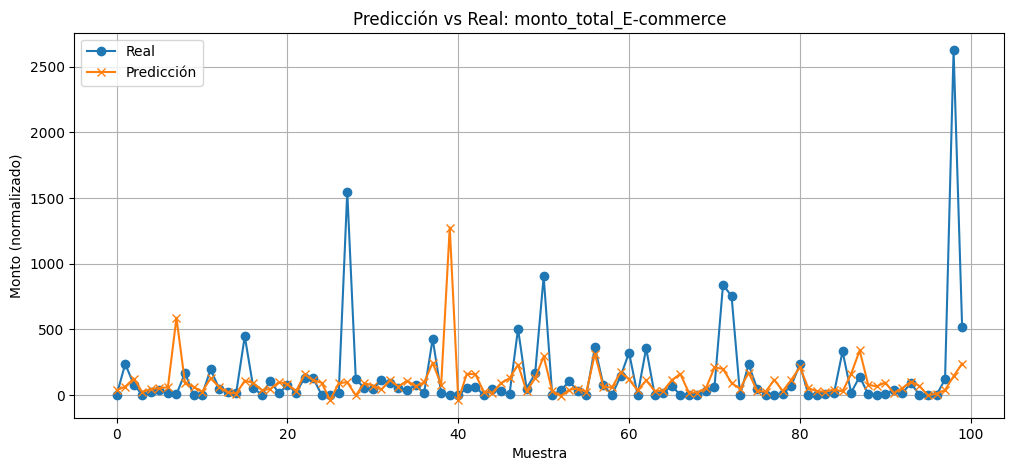

In [9]:
import matplotlib.pyplot as plt

# graficamos los reslutados de las predicciones contra lo real

feature_names = dataset_mensual.drop(columns=["id", "mes"]).columns
categoria = "monto_total_E-commerce"
idx = list(feature_names).index(categoria)

plt.figure(figsize=(12, 5))
plt.plot(y_test_orig[:100, idx], label="Real", marker='o')
plt.plot(y_pred_orig[:100, idx], label="Predicción", marker='x')
plt.title(f"Predicción vs Real: {categoria}")
plt.xlabel("Muestra")
plt.ylabel("Monto (normalizado)")
plt.legend()
plt.grid(True)
plt.show()


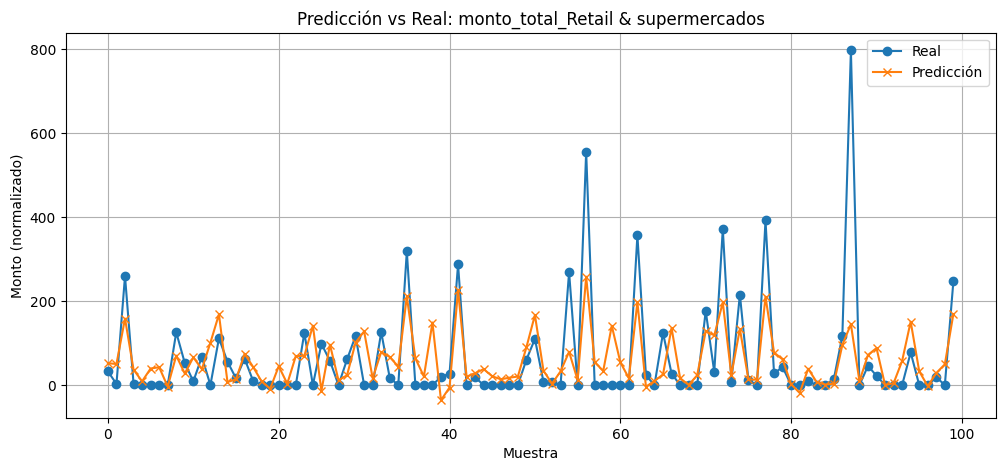

In [10]:

# Segunda gráfica

feature_names = dataset_mensual.drop(columns=["id", "mes"]).columns
categoria = "monto_total_Retail & supermercados"
idx = list(feature_names).index(categoria)

plt.figure(figsize=(12, 5))
plt.plot(y_test_orig[:100, idx], label="Real", marker='o')
plt.plot(y_pred_orig[:100, idx], label="Predicción", marker='x')
plt.title(f"Predicción vs Real: {categoria}")
plt.xlabel("Muestra")
plt.ylabel("Monto (normalizado)")
plt.legend()
plt.grid(True)
plt.show()


# Comparación de datos


Comparamos los datos de un cliente en específico para ver su predicción

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


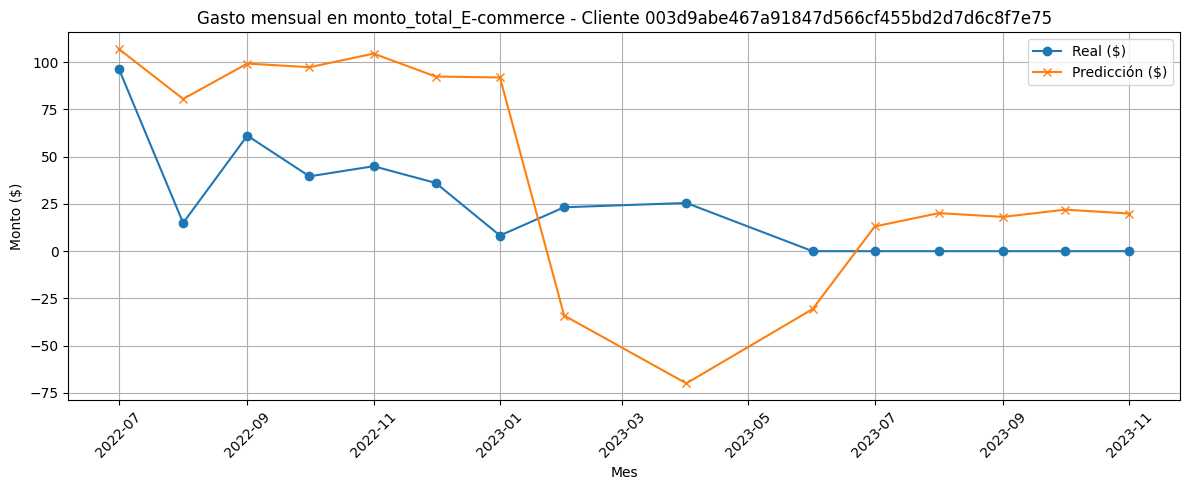

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Comparación de los meses de un cliente y sus predicciones
# === PARAMETROS ===
categoria = "monto_total_E-commerce"
cliente_id = '003d9abe467a91847d566cf455bd2d7d6c8f7e75'
n_pasos = 6

# === Extraer datos reales del cliente ===
cliente_data = dataset_mensual[dataset_mensual["id"] == cliente_id].sort_values("mes")
meses = cliente_data["mes"].values
valores = cliente_data.drop(columns=["id", "mes"]).values
idx_cat = list(dataset_mensual.drop(columns=["id", "mes"]).columns).index(categoria)

# === Construir predicciones por ventana deslizada ===
preds = []
meses_pred = []

for i in range(len(valores) - n_pasos):
    secuencia = valores[i:i+n_pasos]
    mes_objetivo = meses[i + n_pasos]
    pred = model.predict(secuencia[np.newaxis, :, :])[0][idx_cat]
    preds.append(pred)
    meses_pred.append(mes_objetivo)


# === Valores reales de esos meses objetivo ===
reales = valores[n_pasos:, idx_cat]

# === DESNORMALIZAR ===
plantilla_pred = np.zeros((len(preds), len(features)))
plantilla_real = np.zeros((len(reales), len(features)))

plantilla_pred[:, idx_cat] = preds
plantilla_real[:, idx_cat] = reales

preds_desnorm = scaler.inverse_transform(plantilla_pred)[:, idx_cat]
reales_desnorm = scaler.inverse_transform(plantilla_real)[:, idx_cat]

# === Graficar ===
plt.figure(figsize=(12, 5))
plt.plot(meses_pred, reales_desnorm, label="Real ($)", marker='o')
plt.plot(meses_pred, preds_desnorm, label="Predicción ($)", marker='x')
plt.title(f"Gasto mensual en {categoria} - Cliente {cliente_id}")
plt.xlabel("Mes")
plt.ylabel("Monto ($)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculamos métricas


Calculamos las métricas de nuestro modelo para obtener sus resultados

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Métricas del modelo
y_pred = model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print(f"MAE global:  {mae:.2f}")
print(f"RMSE global: {rmse:.2f}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE global:  11.33
RMSE global: 54.63


# Hacemos una predicción de un cliente del siguiente mes

Calculamos los gastos en cada categoría de un cliente en específico para un mes completamente nuevo del cual no tenemos métricas.

In [17]:
#Creamos pedicciones para un mes completamente nuevo

cliente_id = '003d9abe467a91847d566cf455bd2d7d6c8f7e75'
n_pasos = 12 #numero de meses a tomar en cuenta

cliente_data = dataset_mensual[dataset_mensual["id"] == cliente_id].sort_values("mes")
valores = cliente_data.drop(columns=["id", "mes"]).values

# Usamos solo los últimos n_pasos meses
input_secuencia = valores[-n_pasos:]
pred = model.predict(input_secuencia[np.newaxis, :, :])[0]
plantilla = np.zeros((1, len(features)))
plantilla[0, :] = pred


pred_desnorm = scaler.inverse_transform(plantilla)[0]
resultado = dict(zip(features, pred_desnorm))
for cat, valor in resultado.items():
    print(f"{cat:35}: ${valor:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
frecuencia_Apps y servicios digitales: $0.09
frecuencia_Cines & entretenimiento : $0.05
frecuencia_Delivery & comida rápida: $0.11
frecuencia_E-commerce              : $1.31
frecuencia_Hogar & servicios       : $0.00
frecuencia_Movilidad & transporte  : $0.56
frecuencia_OTROS                   : $0.01
frecuencia_Otros giros empresariales: $0.00
frecuencia_Pagos de servicios      : $0.16
frecuencia_Retail & supermercados  : $0.34
frecuencia_Salud & cuidado personal: $0.08
frecuencia_Streaming & entretenimiento digital: $0.28
frecuencia_Viajes & turismo        : $-0.00
monto_promedio_Apps y servicios digitales: $2.24
monto_promedio_Cines & entretenimiento: $1.29
monto_promedio_Delivery & comida rápida: $2.65
monto_promedio_E-commerce          : $13.01
monto_promedio_Hogar & servicios   : $-0.05
monto_promedio_Movilidad & transporte: $3.40
monto_promedio_OTROS               : $1.67
monto_promedio_Otros giros empresariales: $0.36
monto_promedio_Pagos d